In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

In [17]:
htrain = pd.read_csv('train.csv')
htest = pd.read_csv('test.csv')

htrain = htrain.drop('Id', axis=1)

###
##   Note: change "YearBuilt", "YearSold", "YearRM"
#       to "Years Since" vars..
##
###
htrain['YrsOld'] = 2017 - htrain['YearBuilt']
htrain['YrsRM'] = 2017 - htrain['YearRemodAdd']
htrain['YrsSS'] = 2017 - htrain['YrSold']

htrain = htrain.drop(['YearBuilt','YearRemodAdd','YrSold'],axis=1)

htrain.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,YrsOld,YrsRM,YrsSS
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,WD,Normal,208500,14,14,9
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,WD,Normal,181500,41,41,10
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,WD,Normal,223500,16,15,9
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,WD,Abnorml,140000,102,47,11
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,WD,Normal,250000,17,17,9


In [18]:
#%%
# Convert dataframe to all numeric for training models
#
#-------------------------
# Fill NAs with 0 first step
htrain = htrain.fillna(value=0)

# Seperate numerical and non-numerical columns into dataframes
numht = htrain.select_dtypes(include = ['float64','int64'])
nonht = htrain.select_dtypes(exclude = ['float64','int64'])

#Create empty df and pass all columns from non-numeric df 
# converted to categorical
non2 = pd.DataFrame()
for column in nonht:
    non2[column] = pd.Categorical(nonht[column])

#Create another empty df and pass all columns from categorical df
# converted to codes    
nonC = pd.DataFrame()
for column in non2:
    nonC[column] = non2[column].cat.codes
    
#Combine the native numerical and newly converted dataframes
trNum = pd.concat([numht,nonC], axis=1)

trNum.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,65.0,8450,7,5,196.0,706,0,150,856,...,2,2,5,5,2,0,0,0,8,4
1,20,80.0,9600,6,8,0.0,978,0,284,1262,...,2,2,5,5,2,0,0,0,8,4
2,60,68.0,11250,7,5,162.0,486,0,434,920,...,2,2,5,5,2,0,0,0,8,4
3,70,60.0,9550,7,5,0.0,216,0,540,756,...,6,3,5,5,2,0,0,0,8,0
4,60,84.0,14260,8,5,350.0,655,0,490,1145,...,2,2,5,5,2,0,0,0,8,4


Gradient Boosting Accuracy 92.36%


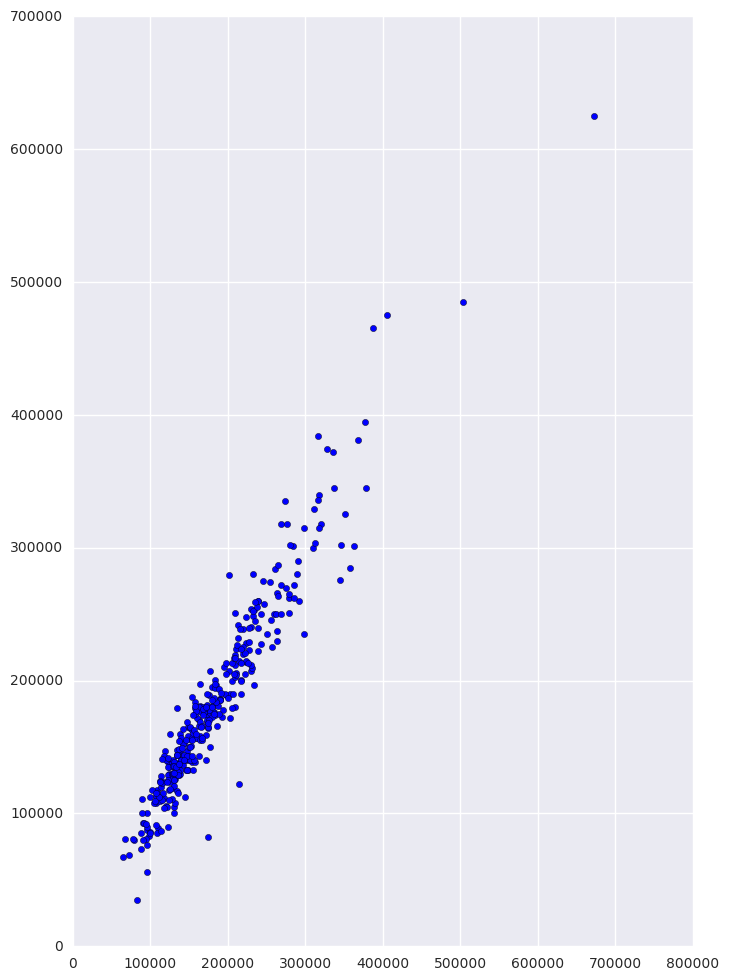

In [22]:
#%%
#Set up training model

np.random.seed(112)

train, test = train_test_split(trNum, test_size = .25)

# Train outcome and predictors 
y = train.SalePrice
X = train.drop('SalePrice', axis=1)

# Test outcome and predictors
yt = test.SalePrice
Xt = test.drop('SalePrice', axis=1)

#%%
#Set model parameters
gbfit = GradientBoostingRegressor(n_estimators=1500, max_depth=5, loss='ls')

#Fit model
gbfit.fit(X=X, y=y)

accuracy = gbfit.score(Xt, yt)
predict = gbfit.predict(Xt)

#%%

# Show results of GBR with all variables

sb.set_style('darkgrid')
plt.scatter(predict, yt)

print('Gradient Boosting Accuracy %s' % '{0:.2%}'.format(accuracy))


Feature Importances
feature MSSubClass (0.085603)
feature LotFrontage (0.069651)
feature LotArea (0.064398)
feature OverallQual (0.051162)
feature OverallCond (0.048349)
feature MasVnrArea (0.047894)
feature BsmtFinSF1 (0.042751)
feature BsmtFinSF2 (0.035420)
feature BsmtUnfSF (0.034165)
feature TotalBsmtSF (0.033783)
feature 1stFlrSF (0.031410)
feature 2ndFlrSF (0.030199)
feature LowQualFinSF (0.029697)
feature GrLivArea (0.027745)
feature BsmtFullBath (0.027528)
feature BsmtHalfBath (0.023300)
feature FullBath (0.021173)
feature HalfBath (0.019455)
feature BedroomAbvGr (0.018612)
feature KitchenAbvGr (0.012926)
feature TotRmsAbvGrd (0.012177)
feature Fireplaces (0.010476)
feature GarageYrBlt (0.009763)
feature GarageCars (0.009719)
feature GarageArea (0.008906)
feature WoodDeckSF (0.008239)
feature OpenPorchSF (0.008013)
feature EnclosedPorch (0.007975)
feature 3SsnPorch (0.007847)
feature ScreenPorch (0.007715)
feature PoolArea (0.007382)
feature MiscVal (0.007237)
feature MoSold (0

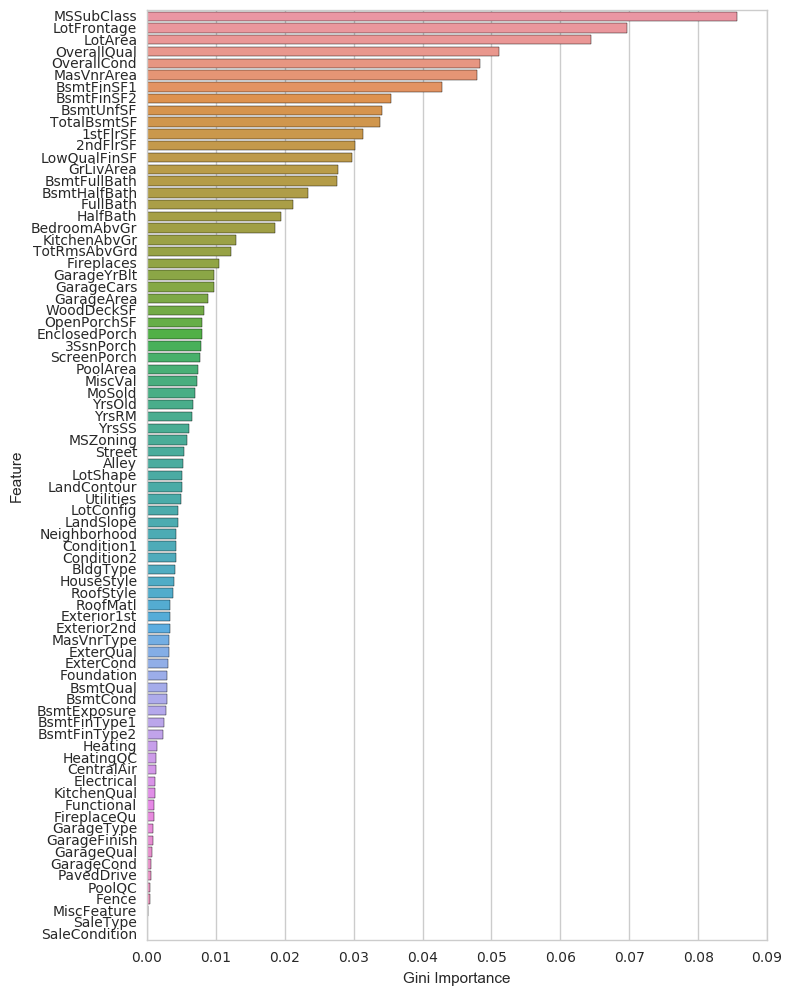

In [21]:
# Model feature importances ranking
importances = gbfit.feature_importances_
indices = np.argsort(importances)[::-1]

print('Feature Importances')

for f in range(X.shape[1]):
    print("feature %s (%f)" % (list(X)[f], importances[indices[f]]))

feat_imp = pd.DataFrame({'Feature':list(X),
                         'Gini Importance':importances[indices]})

plt.rcParams['figure.figsize']=(8,12)
sb.set_style('whitegrid')
ax = sb.barplot(x='Gini Importance', y='Feature', data=feat_imp)
ax.set(xlabel='Gini Importance')
plt.show()    

